## **Learning curve & Complexity curve**

Complexity and learning curve analyses are some of the most important tasks in a Machine Learning project.

**Learning curve:** Graphs that compares the performance of a model on training and testing data over a varying number of training instances. We should generally see performance improve as the number of training points increases.

**Complexity curve:** Graphs that show the model performance over training and validation set for varying degree of model complexity (e.g. degree of polynomial for linear regression, number of layers or neurons for neural networks, number of estimator trees for a Boosting algorithm or Random Forest). Complexity curve allows us to verify when a model has learned as much as it can about the data without fitting to the noise. 

* The key is to find the spot that minimizes bias and variance by finding the right level of model complexity. Of course with more data any model can improve, and different models may be optimal.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set_style("white")

In [8]:
df=pd.read_csv("data/loan_data.csv")
df_final = pd.get_dummies(df,['purpose'],drop_first=True)
df_final = df_final.drop('credit.policy',axis=1)

In [9]:
X=df_final.drop('not.fully.paid',axis=1)
y=df['not.fully.paid']

In [11]:
#divide the set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [12]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50)

print("Shape of validation set:", X_val.shape)
print("Shape of test set:", X_test.shape)
print("Shape of training set:", X_train.shape)

Shape of validation set: (1437, 17)
Shape of test set: (1437, 17)
Shape of training set: (6704, 17)


## **Decision Tree model**

In [13]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='gini',max_depth=10,min_samples_leaf=5)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [14]:
predictions = dtree.predict(X_val)

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

score1=accuracy_score(y_val,predictions)
print(score1)

0.81419624217119


## **Varying hyperparameters: Pruning the tree**

**Varying max_depth**

Looking **max_depth** (max depth of a tree) we see an increase in the validation set accuracy, accompanied by a decrease in training set accuracy for smaller trees. This means that for this dataset, a deeper tree clearly overfits the data and a shallow tree of depth 2/3 should be considered.

In [16]:

val_acc_max_depth=[]
val_f1_max_depth=[]
train_acc_max_depth=[]
train_f1_max_depth=[]
for i in range(3,21):
    dtree = DecisionTreeClassifier(criterion='gini',max_depth=i,min_samples_leaf=1)
    dtree.fit(X_train,y_train)
    pred_train = dtree.predict(X_train)
    pred_val = dtree.predict(X_val)
    acc_train=accuracy_score(y_train,pred_train)
    f1_train = f1_score(y_train,pred_train,average='micro')
    acc_val=accuracy_score(y_val,pred_val)
    f1_val = f1_score(y_val,pred_val,average='micro')
    train_acc_max_depth.append(acc_train)
    train_f1_max_depth.append(f1_train)
    val_acc_max_depth.append(acc_val)
    val_f1_max_depth.append(f1_val)

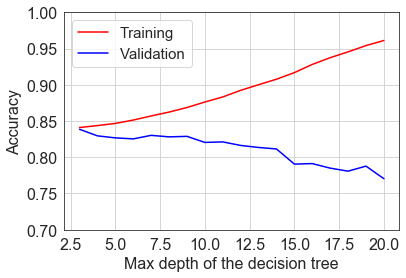

In [17]:

plt.plot(range(3,21),train_acc_max_depth,c='red')
plt.plot(range(3,21),val_acc_max_depth,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Max depth of the decision tree", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.7,1.0)
plt.show()

**min_samples_leaf with max_depth = 20**

With **min_samples_leaf** parameter we limit overfitting. If we allow a single leaf per node then the algorithm will fit to the noise of the data down to a single data point (splitting data on as low as two points) thereby making the decision boundary extremely nonlinear and vulnarable to the nosie.

In [19]:

val_acc_min_samples_leaf=[]
val_f1_min_samples_leaf=[]
train_acc_min_samples_leaf=[]
train_f1_min_samples_leaf=[]
for i in range(1,41):
    dtree = DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_leaf=i)
    dtree.fit(X_train,y_train)
    pred_train = dtree.predict(X_train)
    pred_val = dtree.predict(X_val)
    acc_train=accuracy_score(y_train,pred_train)
    f1_train = f1_score(y_train,pred_train,average='micro')
    acc_val=accuracy_score(y_val,pred_val)
    f1_val = f1_score(y_val,pred_val,average='micro')
    train_acc_min_samples_leaf.append(acc_train)
    train_f1_min_samples_leaf.append(f1_train)
    val_acc_min_samples_leaf.append(acc_val)
    val_f1_min_samples_leaf.append(f1_val)

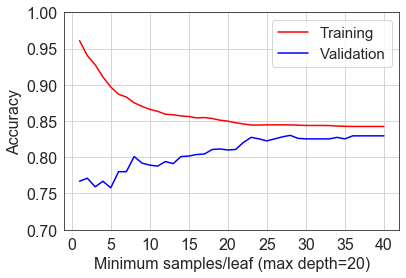

In [21]:

plt.plot(range(1,41),train_acc_min_samples_leaf,c='red')
plt.plot(range(1,41),val_acc_min_samples_leaf,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Minimum samples/leaf (max depth=20)", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.7,1.0)
plt.show()

## **LEARNING CURVE/Varying training set size** 

We run a loop over a range of fractions (10% to 100%) and sample random points up to that fraction from the original data set.

The plot shows that for this dataset and a sensible choice of hyperparameters, **the accuracy is not a strong function of training data size down to small fraction of the original data**. This means, in principle, we can run the algorithm on a much smaller model than using all the data and still create decent predictions.

In [22]:

val_acc_train_size=[]
val_f1_train_size=[]
train_acc_train_size=[]
train_f1_train_size=[]
val_range=(10,101,1)
for i in range(val_range[0],val_range[1],val_range[2]):
    # Fitting
    percentage=i*0.01
    dtree = DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_leaf=20)
    # Sampling
    df_sampled = df_final.sample(frac=percentage)
    X_train_sampled=df_sampled.drop('not.fully.paid',axis=1)
    y_train_sampled=df_sampled['not.fully.paid']
    # Fitting and Predictions
    dtree.fit(X_train_sampled,y_train_sampled)
    pred_train = dtree.predict(X_train_sampled)
    pred_val = dtree.predict(X_val)
    # Accuracy and F1 score
    acc_train=accuracy_score(y_train_sampled,pred_train)
    f1_train = f1_score(y_train_sampled,pred_train,average='micro')
    acc_val=accuracy_score(y_val,pred_val)
    f1_val = f1_score(y_val,pred_val,average='micro')
    # Appending to the lists
    train_acc_train_size.append(acc_train)
    train_f1_train_size.append(f1_train)
    val_acc_train_size.append(acc_val)
    val_f1_train_size.append(f1_val)
    if i%10==0:
        print(f"Done for: {i}% training set size")

Done for: 10% training set size
Done for: 20% training set size
Done for: 30% training set size
Done for: 40% training set size
Done for: 50% training set size
Done for: 60% training set size
Done for: 70% training set size
Done for: 80% training set size
Done for: 90% training set size
Done for: 100% training set size


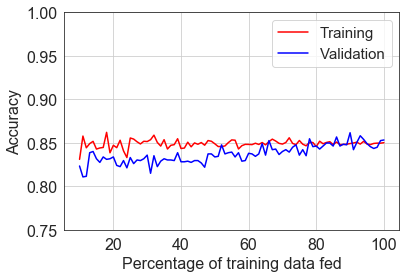

In [23]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_acc_train_size,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_acc_train_size,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Percentage of training data fed", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.75,1.0)
plt.show()

## **SCALE DATA**

In [31]:
from sklearn.preprocessing import StandardScaler
X_train_scaled=StandardScaler().fit_transform(X_train)
X_val_scaled=StandardScaler().fit_transform(X_val)


## **Neural Networks (Multi-layer perceptron)**

In [32]:
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [33]:
n_input=X_train_scaled.shape[0]
num_classes = len(y_train.unique())
input_dim=X_train_scaled.shape[1]

### **Necessary functions to create the network**

In [34]:
##Function to construct 2-hidden-layer Keras model

def make_NN_model(input_dim, num_classes, neuron_layer_1=20, neuron_layer_2=10, dropout_prob=0.25, \
                  activation_func='relu', learning_rate=0.01,optimizer='SGD'):
 
    """
    Creates a 2-hidden-layer Keras Neural Network model by adding densely connected layers, \
    dropout layers, and an output layer with 'softmax' activation with appropriate number of nodes for classification
    """
    model = Sequential()
    model.add(Dense(neuron_layer_1, input_shape=(input_dim,),activation=activation_func))
    model.add(Dropout(dropout_prob))
    model.add(Dense(neuron_layer_2,activation=activation_func))
    #model.add(Dense(50,activation='relu'))
    model.add(Dropout(dropout_prob))
    # Softmax activation for the last layer for classification
    model.add(Dense(1, activation='sigmoid'))
    
    if optimizer=='SGD':
        optimizer=keras.optimizers.SGD(lr=learning_rate)
    if optimizer=='Adam':
        optimizer=keras.optimizers.Adam(lr=learning_rate)
    if optimizer=='RMSprop':
        optimizer=keras.optimizers.RMSprop(lr=learning_rate)
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
    
    return model

##Function to run the NN model

def run_NN(model,X_train,y_train,X_val,y_val,num_epochs=200,batch_size=16,plot_loss=False,verbosity=0):
    #save best model as checkpointer
    from keras.callbacks import ModelCheckpoint
    checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', 
                                   verbose=verbosity, save_best_only=True)
    
    # train the model
    hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,
              validation_data=(X_val, y_val), 
              verbose=verbosity, shuffle=False)
    
    if plot_loss:
        plt.plot(hist.history['acc'],color='red')
        plt.plot(hist.history['val_acc'],color='blue')
        plt.title("Training and validation set accuracy",fontsize=15)
        plt.grid(True)
        plt.xlabel("Epochs",fontsize=14)
        plt.legend(['Training','Validation'])
        plt.show()
    
    return hist

##Function to test the NN model

def test_NN(hist,X_test,y_test):
    """
    Test a NN model with test data set for accuracy
    hist: A History object generated by the Keras model fitting process
    """
    score=hist.model.evaluate(X_test, y_test,verbose=0)[1]
    return score

## **Choice of optimizer**

There are many choices of optimizers which perform backpropagation for MLP. We try two of the most common optimizers to see their impact on the speed of convergence. The results show that for this dataset, Adam optimizer reaches convergence faster i.e. in lesser number of epochs than conventional stochastic gradient descent (SGD). Another distinct feature of this set of results is that they show that in case of MLP, the validation accuracy tracks the training accuracy closely. This kind of parallel trend is not seen in other type of algorithms.

**Adam**

In [35]:
nn_model=make_NN_model(input_dim=input_dim,num_classes=num_classes,dropout_prob=0.0,learning_rate=0.0001,
                      neuron_layer_1=10,neuron_layer_2=5,optimizer='Adam')






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where





Train on 6704 samples, validate on 1437 samples
Epoch 1/25





6704/6704 [==============================] - 0s 73us/step - loss: 0.7219 - acc: 0.5461 - val_loss: 0.7059 - val_acc: 0.5685
Epoch 2/25
6704/6704 [==============================] - 0s 12us/step - loss: 0.6943 - acc: 0.5947 - val_loss: 0.6806 - val_acc: 0.6152
Epoch 3/25
6704/6704 [==============================] - 0s 12us/step - loss: 0.6704 - acc: 0.6402 - val_loss: 0.6582 - val_acc: 0.6604
Epoch 4/25
6704/6704 [==============================] - 0s 11us/step - loss: 0.6492 - acc: 0.6885 - val_loss: 0.6380 - val_acc: 0.7063
Epoch 5/25
6704/6704 [==============================] - 0s 11us/step - loss: 0.6299 - acc: 0.7242 - val_loss: 0.6195 - val_acc: 0.7446
Epoch 6/25
6704/6704 [==============================] - 0s 10us/step - loss: 0.6118 - acc: 0.7549 - val_loss: 0.6021 - val_acc: 0.7662
Epoch 7/25
6704/6704 [==============================] - 0s 11us/step - loss: 0.5947 - acc: 0.7807 - val_loss: 0.5855 - val_acc: 0.7878

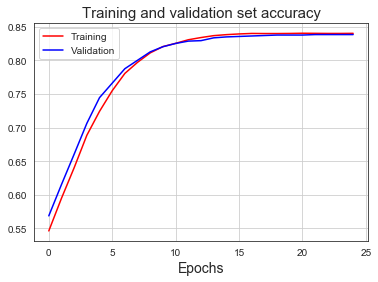

In [36]:
hist=run_NN(nn_model,X_train_scaled,y_train,X_val_scaled,y_val,verbosity=1,batch_size=64,
            num_epochs=25,plot_loss=True)

## **Stochastic Gradient Descent optimizer**

In [37]:
nn_model=make_NN_model(input_dim=input_dim,num_classes=num_classes,dropout_prob=0.0,learning_rate=0.0001,
                      neuron_layer_1=10,neuron_layer_2=5,optimizer='SGD')

Train on 6704 samples, validate on 1437 samples
Epoch 1/25
6704/6704 [==============================] - 0s 43us/step - loss: 0.5834 - acc: 0.7598 - val_loss: 0.5774 - val_acc: 0.7467
Epoch 2/25
6704/6704 [==============================] - 0s 10us/step - loss: 0.5822 - acc: 0.7661 - val_loss: 0.5761 - val_acc: 0.7530
Epoch 3/25
6704/6704 [==============================] - 0s 10us/step - loss: 0.5809 - acc: 0.7697 - val_loss: 0.5748 - val_acc: 0.7592
Epoch 4/25
6704/6704 [==============================] - 0s 11us/step - loss: 0.5797 - acc: 0.7755 - val_loss: 0.5736 - val_acc: 0.7648
Epoch 5/25
6704/6704 [==============================] - 0s 11us/step - loss: 0.5785 - acc: 0.7800 - val_loss: 0.5723 - val_acc: 0.7690
Epoch 6/25
6704/6704 [==============================] - 0s 10us/step - loss: 0.5772 - acc: 0.7824 - val_loss: 0.5711 - val_acc: 0.7731
Epoch 7/25
6704/6704 [==============================] - 0s 11us/step - loss: 0.5760 - acc: 0.7873 - val_loss: 0.5699 - val_acc: 0.7752
Epoch 8

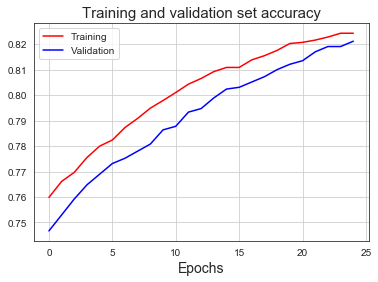

In [38]:
hist=run_NN(nn_model,X_train_scaled,y_train,X_val_scaled,y_val,verbosity=1,batch_size=64,
            num_epochs=25,plot_loss=True)

## **Number of neurons per layer? & How many epochs should we run for?**

These are some of the natural questions that arise for an MLP. With our helper function, we run a loop over a wide range of neurons/hidden layer, extract training and validation accuracy, and show that the accuracy varies wildly with the model complexity i.e. number of neurons when we train it for small number of epochs. But this variation is smoothed out with large number of epochs.

**Running for num_epochs = 5**

In [39]:
train_acc_n=[]
val_acc_n=[]

val_range=(2,21,1)
for i in range(val_range[0],val_range[1],val_range[2]):
    # Fitting
    nn_model=make_NN_model(input_dim=input_dim,num_classes=num_classes,dropout_prob=0.0,learning_rate=0.0001,
                      neuron_layer_1=i,neuron_layer_2=i,optimizer='Adam')
    hist=run_NN(nn_model,X_train_scaled,y_train,X_val_scaled,y_val,verbosity=0,batch_size=256,
            num_epochs=5,plot_loss=False)
    # Accuracy score
    acc_train=hist.model.evaluate(X_train_scaled, y_train,verbose=0)[1]
    acc_val=hist.model.evaluate(X_val_scaled,y_val,verbose=0)[1]
   # Appending to the lists
    train_acc_n.append(acc_train)
    val_acc_n.append(acc_val)
    print(f"Done for number of neurons (each hidden layer): {i}")


Done for number of neurons (each hidden layer): 2
Done for number of neurons (each hidden layer): 3
Done for number of neurons (each hidden layer): 4
Done for number of neurons (each hidden layer): 5
Done for number of neurons (each hidden layer): 6
Done for number of neurons (each hidden layer): 7
Done for number of neurons (each hidden layer): 8
Done for number of neurons (each hidden layer): 9
Done for number of neurons (each hidden layer): 10
Done for number of neurons (each hidden layer): 11
Done for number of neurons (each hidden layer): 12
Done for number of neurons (each hidden layer): 13
Done for number of neurons (each hidden layer): 14
Done for number of neurons (each hidden layer): 15
Done for number of neurons (each hidden layer): 16
Done for number of neurons (each hidden layer): 17
Done for number of neurons (each hidden layer): 18
Done for number of neurons (each hidden layer): 19
Done for number of neurons (each hidden layer): 20


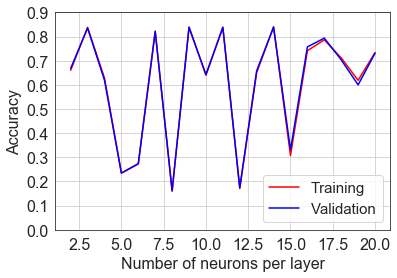

In [40]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_acc_n,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_acc_n,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Number of neurons per layer", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.0,0.9)
plt.show()

**Running for num_epochs = 10**

In [41]:
train_acc_n=[]
val_acc_n=[]

val_range=(2,21,1)
for i in range(val_range[0],val_range[1],val_range[2]):
    # Fitting
    nn_model=make_NN_model(input_dim=input_dim,num_classes=num_classes,dropout_prob=0.0,learning_rate=0.0001,
                      neuron_layer_1=i,neuron_layer_2=i,optimizer='Adam')
    hist=run_NN(nn_model,X_train_scaled,y_train,X_val_scaled,y_val,verbosity=0,batch_size=256,
            num_epochs=10,plot_loss=False)
    # Accuracy score
    acc_train=hist.model.evaluate(X_train_scaled, y_train,verbose=0)[1]
    acc_val=hist.model.evaluate(X_val_scaled,y_val,verbose=0)[1]
   # Appending to the lists
    train_acc_n.append(acc_train)
    val_acc_n.append(acc_val)
    print(f"Done for number of neurons (each hidden layer): {i}")


Done for number of neurons (each hidden layer): 2
Done for number of neurons (each hidden layer): 3
Done for number of neurons (each hidden layer): 4
Done for number of neurons (each hidden layer): 5
Done for number of neurons (each hidden layer): 6
Done for number of neurons (each hidden layer): 7
Done for number of neurons (each hidden layer): 8
Done for number of neurons (each hidden layer): 9
Done for number of neurons (each hidden layer): 10
Done for number of neurons (each hidden layer): 11
Done for number of neurons (each hidden layer): 12
Done for number of neurons (each hidden layer): 13
Done for number of neurons (each hidden layer): 14
Done for number of neurons (each hidden layer): 15
Done for number of neurons (each hidden layer): 16
Done for number of neurons (each hidden layer): 17
Done for number of neurons (each hidden layer): 18
Done for number of neurons (each hidden layer): 19
Done for number of neurons (each hidden layer): 20


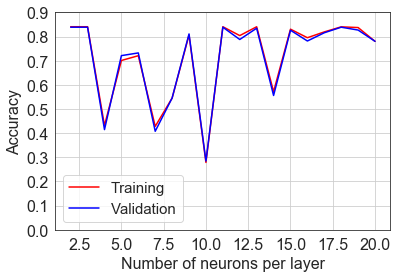

In [42]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_acc_n,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_acc_n,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Number of neurons per layer", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.0,0.9)
plt.show()

## **Running for num_epochs = 25**

In [43]:
train_acc_n=[]
val_acc_n=[]

val_range=(2,21,1)
for i in range(val_range[0],val_range[1],val_range[2]):
    # Fitting
    nn_model=make_NN_model(input_dim=input_dim,num_classes=num_classes,dropout_prob=0.0,learning_rate=0.0001,
                      neuron_layer_1=i,neuron_layer_2=i,optimizer='Adam')
    hist=run_NN(nn_model,X_train_scaled,y_train,X_val_scaled,y_val,verbosity=0,batch_size=256,
            num_epochs=25,plot_loss=False)
    # Accuracy score
    acc_train=hist.model.evaluate(X_train_scaled, y_train,verbose=0)[1]
    acc_val=hist.model.evaluate(X_val_scaled,y_val,verbose=0)[1]
   # Appending to the lists
    train_acc_n.append(acc_train)
    val_acc_n.append(acc_val)
    print(f"Done for number of neurons (each hidden layer): {i}")

Done for number of neurons (each hidden layer): 2
Done for number of neurons (each hidden layer): 3
Done for number of neurons (each hidden layer): 4
Done for number of neurons (each hidden layer): 5
Done for number of neurons (each hidden layer): 6
Done for number of neurons (each hidden layer): 7
Done for number of neurons (each hidden layer): 8
Done for number of neurons (each hidden layer): 9
Done for number of neurons (each hidden layer): 10
Done for number of neurons (each hidden layer): 11
Done for number of neurons (each hidden layer): 12
Done for number of neurons (each hidden layer): 13
Done for number of neurons (each hidden layer): 14
Done for number of neurons (each hidden layer): 15
Done for number of neurons (each hidden layer): 16
Done for number of neurons (each hidden layer): 17
Done for number of neurons (each hidden layer): 18
Done for number of neurons (each hidden layer): 19
Done for number of neurons (each hidden layer): 20


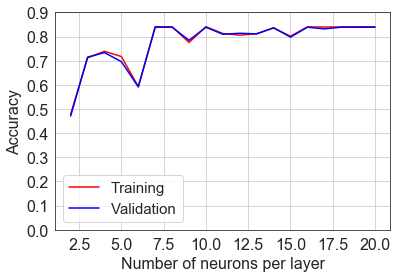

In [44]:

plt.plot(range(val_range[0],val_range[1],val_range[2]),train_acc_n,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_acc_n,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Number of neurons per layer", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.0,0.9)
plt.show()

## **LEARNING CURVE**

Neural networks are known for their insatiable hunger for data! We plot the learning curve to see the expected variation of performance for smaller training set size. However, for this dataset, we also found that by dialing the learning rate parameter higher, we can mostly smooth out this variation i.e. make the network learn on a smaller subset of training data. It is not recommended for all types of network and tuning the learning rate is an art. But it worked for this dataset.

In [ ]:
val_acc_train_size=[]
train_acc_train_size=[]

val_range=(10,101,5)
for i in range(val_range[0],val_range[1],val_range[2]):
    percentage=i*0.01
    # Sampling
    df_sampled = df_final.sample(frac=percentage)
    X_train_sampled=df_sampled.drop('not.fully.paid',axis=1)
    y_train_sampled=df_sampled['not.fully.paid']
    X_train_sampled=StandardScaler().fit_transform(X_train_sampled)
    # Fitting and Predictions
    nn_model=make_NN_model(input_dim=input_dim,num_classes=num_classes,dropout_prob=0.0,learning_rate=0.0001,
                      neuron_layer_1=5,neuron_layer_2=5,optimizer='Adam')
    hist=run_NN(nn_model,X_train_sampled,y_train_sampled,X_val_scaled,y_val,verbosity=0,batch_size=256,
            num_epochs=25,plot_loss=False)
    # Accuracy score
    acc_train=hist.model.evaluate(X_train_sampled, y_train_sampled,verbose=0)[1]
    acc_val=hist.model.evaluate(X_val_scaled,y_val,verbose=0)[1]
   # Appending to the lists
    train_acc_train_size.append(acc_train)
    val_acc_train_size.append(acc_val)
    
    print(f"Done for: {i}% training set size")


Done for: 10% training set size
Done for: 15% training set size
Done for: 20% training set size
Done for: 25% training set size
Done for: 30% training set size
Done for: 35% training set size
Done for: 40% training set size
Done for: 45% training set size
Done for: 50% training set size
Done for: 55% training set size
Done for: 60% training set size
Done for: 65% training set size
Done for: 70% training set size


In [ ]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_acc_train_size,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_acc_train_size,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(np.arange(0, 110, step=10),fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Percentage of training data fed", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
#plt.ylim(0.8,0.9)
plt.xlim(0,110)
plt.show()


**To smooth out the dependence on training set size, can we tweak the learning rate?**

In [ ]:
val_acc_train_size=[]
train_acc_train_size=[]

val_range=(10,101,5)
for i in range(val_range[0],val_range[1],val_range[2]):
    percentage=i*0.01
    # Sampling
    df_sampled = df_final.sample(frac=percentage)
    X_train_sampled=df_sampled.drop('not.fully.paid',axis=1)
    y_train_sampled=df_sampled['not.fully.paid']
    X_train_sampled=StandardScaler().fit_transform(X_train_sampled)
    # Fitting and Predictions
    nn_model=make_NN_model(input_dim=input_dim,num_classes=num_classes,dropout_prob=0.0,learning_rate=0.001,
                      neuron_layer_1=5,neuron_layer_2=5,optimizer='Adam')
    hist=run_NN(nn_model,X_train_sampled,y_train_sampled,X_val_scaled,y_val,verbosity=0,batch_size=256,
            num_epochs=25,plot_loss=False)
    # Accuracy score
    acc_train=hist.model.evaluate(X_train_sampled, y_train_sampled,verbose=0)[1]
    acc_val=hist.model.evaluate(X_val_scaled,y_val,verbose=0)[1]
   # Appending to the lists
    train_acc_train_size.append(acc_train)
    val_acc_train_size.append(acc_val)
    
    print(f"Done for: {i}% training set size")

In [ ]:
plt.plot(range(val_range[0],val_range[1],val_range[2]),train_acc_train_size,c='red')
plt.plot(range(val_range[0],val_range[1],val_range[2]),val_acc_train_size,c='blue')
plt.legend(["Training","Validation"],fontsize=15)
plt.grid(True)
plt.xticks(np.arange(0, 110, step=10),fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Percentage of training data fed (lr=0.001)", fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.ylim(0.5,0.9)
plt.xlim(0,110)
plt.show()